## Homework

In this homework, we'll deploy the ride duration model in batch mode. Like in homework 1, we'll use the Yellow Taxi Trip Records dataset.

Dataset Source : https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page

You'll find the starter code in the [homework](https://github.com/DataTalksClub/mlops-zoomcamp/tree/main/cohorts/2024/04-deployment/homework) directory.


## Q1. Notebook

We'll start with the same notebook we ended up with in homework 1.
We cleaned it a little bit and kept only the scoring part. You can find the initial notebook [here](https://github.com/DataTalksClub/mlops-zoomcamp/blob/main/cohorts/2024/04-deployment/homework/starter.ipynb).

Run this notebook for the March 2023 data.

What's the standard deviation of the predicted duration for this dataset?

* 1.24
* 6.24
* 12.28
* 18.28

In [14]:
import pickle
import pandas as pd
import sklearn

# saved model was from sklearn 1.5.0; use same version to predict.
print(sklearn.__version__)
del sklearn

1.5.0


In [15]:
!python -V

Python 3.12.3


In [16]:
with open('model.bin', 'rb') as f_in:
    dv, model = pickle.load(f_in)

In [17]:
categorical = ['PULocationID', 'DOLocationID']

def read_data(filename):
    df = pd.read_parquet(filename)
    
    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df['duration'] = df.duration.dt.total_seconds() / 60

    df = df[(df.duration >= 1) & (df.duration <= 60)].copy()

    df[categorical] = df[categorical].fillna(-1).astype('int').astype('str')
    
    return df

In [34]:
year = 2023
month = 3
taxi_type = 'yellow'

In [27]:
df = read_data(f'https://d37ci6vzurychx.cloudfront.net/trip-data/{taxi_type}_tripdata_{year:04d}-{month:02d}.parquet')

In [28]:
dicts = df[categorical].to_dict(orient='records')
X_val = dv.transform(dicts)
y_pred = model.predict(X_val)

In [29]:
y_pred.std()

6.247488852238703

## Q2. Preparing the output

Like in the course videos, we want to prepare the dataframe with the output. 

First, let's create an artificial `ride_id` column:

```python
df['ride_id'] = f'{year:04d}/{month:02d}_' + df.index.astype('str')
```

Next, write the ride id and the predictions to a dataframe with results. 

Save it as parquet:

```python
df_result.to_parquet(
    output_file,
    engine='pyarrow',
    compression=None,
    index=False
)
```

What's the size of the output file?

* 36M
* 46M
* 56M
* 66M

__Note:__ Make sure you use the snippet above for saving the file. It should contain only these two columns. For this question, don't change the
dtypes of the columns and use `pyarrow`, not `fastparquet`. 

In [31]:
df['ride_id'] = f'{year:04d}/{month:02d}_' + df.index.astype('str')
df['y_pred'] = y_pred

In [32]:
df_result = df[['ride_id', 'y_pred']].copy()
df_result.head()

,ride_id,y_pred
0,2023/03_0,16.245906
1,2023/03_1,26.134796
2,2023/03_2,11.884264
3,2023/03_3,11.997720
4,2023/03_4,10.234486


In [35]:
output_file = f'output/{taxi_type}/{year:04d}-{month:02d}.parquet'

In [37]:
df_result.to_parquet(
    output_file,
    engine='pyarrow',
    compression=None,
    index=False
)

>> File Size : 65.4 MB
<br> 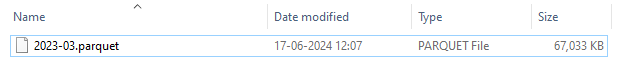

## Q3. Creating the scoring script

Now let's turn the notebook into a script. 

Which command you need to execute for that?

>> Command Used :
<br> jupyter nbconvert --to script model_scorer.ipynb

## Q4. Virtual environment

Now let's put everything into a virtual environment. We'll use pipenv for that.

Install all the required libraries. Pay attention to the Scikit-Learn version: it should be the same as in the starter
notebook.

After installing the libraries, pipenv creates two files: `Pipfile`
and `Pipfile.lock`. The `Pipfile.lock` file keeps the hashes of the
dependencies we use for the virtual env.

What's the first hash for the Scikit-Learn dependency?

Learn more about pipenv : https://www.infoworld.com/article/3561758/how-to-manage-python-projects-with-pipenv.html#:~:text=Set%20up%20a%20new%20project%20with%20Pipenv,-To%20begin%20a&text=Open%20a%20console%20in%20your,%2C%20black%3D%3D13.0b1%20).

>> Commands Used:

- pip install pipenv
- pipenv install scikit-learn==1.5.0
- pipenv install pandas
- pipenv install pyarrow
- [to activate the virtual env] pip shell

>> First hash for sklearn in pipfile.lock :
<br> 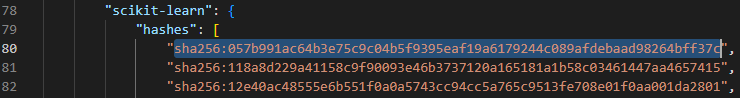

## Q5. Parametrize the script

Let's now make the script configurable via CLI. We'll create two 
parameters: year and month.

Run the script for April 2023. 

What's the mean predicted duration? 

* 7.29
* 14.29
* 21.29
* 28.29

Hint: just add a print statement to your script.

>> Commands used :
- pipenv shell
- python model_scorer.py 2023 4

>>Mean predicted duration :
<br> 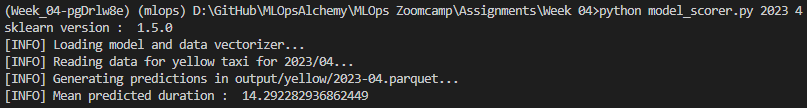

## Q6. Docker container 

Finally, we'll package the script in the docker container. 
For that, you'll need to use a base image that we prepared. 

This is what the content of this image is:
```
FROM python:3.10.13-slim

WORKDIR /app
COPY [ "model2.bin", "model.bin" ]
```

Note: you don't need to run it. We have already done it.

It is pushed it to [`agrigorev/zoomcamp-model:mlops-2024-3.10.13-slim`](https://hub.docker.com/layers/agrigorev/zoomcamp-model/mlops-2024-3.10.13-slim/images/sha256-f54535b73a8c3ef91967d5588de57d4e251b22addcbbfb6e71304a91c1c7027f?context=repo),
which you need to use as your base image.

That is, your Dockerfile should start with:

```docker
FROM agrigorev/zoomcamp-model:mlops-2024-3.10.13-slim

# do stuff here
```

This image already has a pickle file with a dictionary vectorizer
and a model. You will need to use them.

Important: don't copy the model to the docker image. You will need
to use the pickle file already in the image. 

Now run the script with docker. What's the mean predicted duration
for May 2023? 

* 0.19
* 7.24
* 14.24
* 21.19

>> Mean predicted duration for May 2023 : 14.242595513316317

## Bonus: upload the result to the cloud (Not graded)

Just printing the mean duration inside the docker image 
doesn't seem very practical. Typically, after creating the output 
file, we upload it to the cloud storage.

Modify your code to upload the parquet file to S3/GCS/etc.


## Bonus: Use Mage for batch inference

Here we didn't use any orchestration. In practice we usually do.

* Split the code into logical code blocks
* Use Mage to orchestrate the execution

## Publishing the image to dockerhub

This is how we published the image to Docker hub:

```bash
docker build -t mlops-zoomcamp-model:2024-3.10.13-slim .
docker tag mlops-zoomcamp-model:2024-3.10.13-slim agrigorev/zoomcamp-model:mlops-2024-3.10.13-slim

docker login --username USERNAME
docker push agrigorev/zoomcamp-model:mlops-2024-3.10.13-slim
```

This is just for your reference, you don't need to do it.

>> Bonus Parts not done yet [scope for future improvements]